## Q1
1. $p(\beta|y, X, \Sigma) \propto p(y| X, \beta, \Sigma)p(\beta) \propto e^{-\frac{1}{2}(-2\beta^{T}X^{T}\Sigma^{-1}Y+\beta^{T}X^{T}\Sigma^{-1}X\beta)}e^{-\frac{1}{2}(\beta^{T}\Sigma_{\beta}^{-1}\beta-2\beta^{T}\Sigma_{\beta}^{-1}\beta_0)}$

  Let $S^{-1} = X^{T}\Sigma^{-1}X+\Sigma_{\beta}^{-1}$

$p(\beta|y, X, \Sigma) \propto e^{-\frac{1}{2}((\beta - S(X^{T}\Sigma^{-1}Y+\Sigma_{\beta}^{-1}\beta_0))^{T}S^{-1}(\beta - S(X^{T}\Sigma^{-1}Y+\Sigma_{\beta}^{-1}\beta_0)))} \propto MVN(\mu_{post} = S(X^{T}\Sigma^{-1}Y+\Sigma_{\beta}^{-1}\beta_0), \Sigma_{post} = S)$

2.  $p(\sigma^2|y, X, \beta) \propto p(y| X, \beta, I\sigma^2)p(\sigma^2) \propto \frac{1}{|I\sigma^2|}e^{-0.5((y-X\beta)^{T}(I\sigma^2)^{-1}(y-X\beta))}(\sigma^2)^{-\alpha^*-1}e^{-\frac{\beta^*}{\sigma^2}} = \frac{(\sigma^2)^{-\alpha^*-1}}{\sigma^n}e^{\frac{-0.5(y-X\beta)^{T}(y-X\beta)}{\sigma^2} - \frac{\beta^*}{\sigma^2}} = (\sigma^2)^{-(\alpha^*+\frac{n}{2})-1}e^{\frac{-0.5(y-X\beta)^{T}(y-X\beta)-\beta^*}{\sigma^2}} \propto InverseGamma(\alpha_{post} = \alpha^*+\frac{n}{2}, \beta_{post} = \frac{1}{2}(y-X\beta)^{T}(y-X\beta)+\beta^*)$

We may use $\beta = \hat{\beta} = (X^TX)^{-1}X^TY$ if we're trying to sample $\sigma^2$ and $\beta$ simultaneously.

In [1]:
# Q2
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

url = "https://media.geeksforgeeks.org/wp-content/uploads/20240522154350/Fish[1].csv"
fish_data0 = pd.read_csv(url)
print(fish_data0.describe())
y_weight = np.array(fish_data0["Weight"])
fish_data = fish_data0.drop("Weight", axis = 1)
fish_data[["Length1", "Length2", "Length3", "Height", "Width"]] = fish_data[["Length1", "Length2", "Length3", "Height", "Width"]].subtract(fish_data[["Length1", "Length2", "Length3", "Height", "Width"]].mean())
fish_data = pd.get_dummies(fish_data, columns=["Species"], prefix='', prefix_sep='', drop_first=True, dtype = int)
fish_data = pd.concat([pd.DataFrame([1]*fish_data.shape[0]), fish_data], axis = 1)
print(fish_data.head())
X = np.matrix(fish_data)
n, p = X.shape

            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean    398.326415   26.247170   28.415723   31.227044    8.970994    4.417486
std     357.978317    9.996441   10.716328   11.610246    4.286208    1.685804
min       0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     120.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%     273.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%     650.000000   32.700000   35.500000   39.650000   12.365900    5.584500
max    1650.000000   59.000000   63.400000   68.000000   18.957000    8.142000
   0  Length1   Length2   Length3    Height     Width  Parkki  Perch  Pike  \
0  1 -3.04717 -3.015723 -1.227044  2.549006 -0.397486       0      0     0   
1  1 -2.24717 -2.115723 -0.027044  3.509006 -0.111886       0      0     0   
2  1 -2.34717 -1.915723 -0.127044  3.406806  0.278614  

In [2]:
with pm.Model() as LR:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) 
    y = pm.Normal('y', mu=X@betas, sigma=sigma, observed=y_weight)
    
with LR:
    idata = pm.sample()
    
az.summary(idata, round_to=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],12.00952,0.97887,10.16528,13.84334,0.01345,0.00956,5307.39113,2995.28175,1.00291
betas[1],7.96534,0.86717,6.32345,9.57621,0.01375,0.00974,3969.93222,3279.96321,1.00025
betas[2],8.66305,0.83999,7.16000,10.29746,0.01313,0.00933,4097.68455,2994.70273,1.00013
betas[3],9.61860,0.81676,8.15765,11.20188,0.01294,0.00920,3995.14121,2933.79555,1.00015
betas[4],5.83810,0.86690,4.21449,7.41543,0.01032,0.00731,7057.83703,2931.38848,1.00022
betas[5],2.35107,0.98265,0.57824,4.23082,0.01355,0.01019,5281.61578,2491.13402,1.00149
betas[6],0.76542,0.99743,-1.25592,2.51154,0.01264,0.01363,6302.00058,2331.55681,1.00058
betas[7],4.35344,0.99698,2.48528,6.20843,0.01282,0.00925,6059.13318,2861.52200,1.00119
betas[8],0.88789,0.96974,-0.84870,2.77062,0.01283,0.01147,5715.46168,3332.00992,1.00100
betas[9],1.23602,0.99290,-0.62828,3.09271,0.01160,0.01110,7296.04291,3106.69669,1.00230


Standard Deviation in weight data: 356.8508229894959
Estimated standard deviation in weight: 71.4


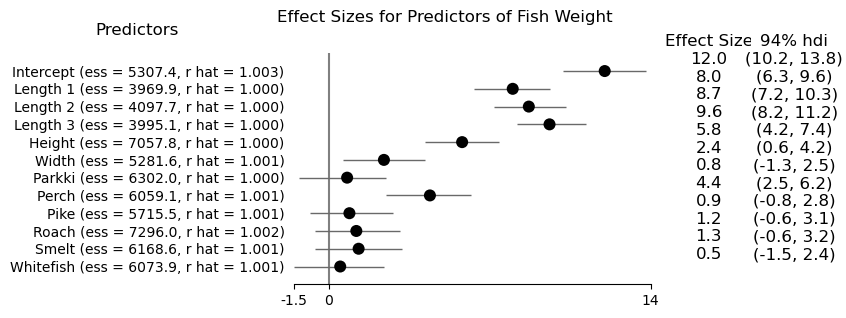

In [19]:
import matplotlib.image as mpimg
import zepid
from zepid.graphics import EffectMeasurePlot

summ = az.summary(idata, round_to=1)
print("Standard Deviation in weight data:", np.var(y_weight)**0.5)
print("Estimated standard deviation in weight:", summ["mean"]["sigma"])
labs = ["Intercept (ess = 5307.4, r hat = 1.003)",
        "Length 1 (ess = 3969.9, r hat = 1.000)",
        "Length 2 (ess = 4097.7, r hat = 1.000)",
        "Length 3 (ess = 3995.1, r hat = 1.000)",
        "Height (ess = 7057.8, r hat = 1.000)",
       "Width (ess = 5281.6, r hat = 1.001)",
       "Parkki (ess = 6302.0, r hat = 1.000)",
       "Perch (ess = 6059.1, r hat = 1.001)",
       "Pike (ess = 5715.5, r hat = 1.001)",
       "Roach (ess = 7296.0, r hat = 1.002)",
       "Smelt (ess = 6168.6, r hat = 1.001)",
       "Whitefish (ess = 6073.9, r hat = 1.001)"]
measure = list(summ["mean"])[:-1]
lower = list(summ["hdi_3%"])[:-1]
upper = list(summ["hdi_97%"])[:-1]
p = EffectMeasurePlot(label=labs, effect_measure=measure, lcl=lower, ucl=upper)
p.labels(effectmeasure='Effect Size', conf_int = "94% hdi", center = 0)
p.colors(pointshape="o")
ax=p.plot(figsize=(7,3), t_adjuster=0.09, max_value=14, min_value=-1.5)
plt.title("Effect Sizes for Predictors of Fish Weight",loc="center",x=-1.3, y=1.1)
plt.suptitle("Predictors",x=-0.1,y=0.98)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.show()

For the different types of fish, only Perch seem to have significantly different weights from the baseline Bream. All dimensions (lengths, width, and height) significantly impact the weight of the fish, which makes sense. 

The $\hat r$'s of all sets of sampling chains are all close to 1, indicating okay priors and enough samples were specified to allow for similar sampling chains. The bulk effective sample sizes are much larger than the 4 000 total draws, suggesting efficient sampling and well determined $\beta$ estimates. The tail effective sample sizes are around 60-75% the magnitude of the 4 000 total draws, which is expected and further indicates that nothing pathological occured during sampling.

In [5]:
# Q3

# add an unexpectedly heavy and light fish
outlier_obs = [[1, -5, -5, -5, -5, -5, 0, 0, 0, 0, 0, 0], [1, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0]]
outlier_y = [2000, 10]

X_out = np.append(X, outlier_obs, axis = 0)
y_out = np.append(y_weight, outlier_y, axis = 0)
n, p = X_out.shape
with pm.Model() as LR_out:
    betas_out = pm.Normal('betas', mu=0, sigma=1, shape=p)
    nu = pm.TruncatedNormal('nu', mu=1, sigma=1, lower=0)
    taui = pm.Gamma('taui', alpha = nu/2, beta = nu/2, shape = n)
    tau = pm.TruncatedNormal('tau', mu=1, sigma=1, lower=0)
    y = pm.Normal('y', mu=X_out@betas_out, sigma=1/(tau*taui)**0.5, observed=y_out, shape = n)
    
with LR_out:
    idata_out = pm.sample()

az.summary(idata_out, round_to=5).filter(regex='betas\[\d*\]|tau$|nu', axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, nu, taui, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.30801,0.98284,-1.42053,2.27099,0.00996,0.01770,9654.60148,2636.25596,0.99987
betas[1],1.04699,0.98554,-0.85219,2.83649,0.01218,0.01159,6553.50225,3034.15254,0.99974
betas[2],1.13771,0.97310,-0.64592,2.98779,0.01108,0.01095,7745.02251,2817.59146,1.00075
betas[3],1.27589,0.96724,-0.49443,3.14877,0.01229,0.01124,6166.80894,2820.28959,1.00157
betas[4],0.46084,0.99481,-1.43522,2.31601,0.01002,0.01498,9859.82565,2791.45187,1.00062
betas[5],0.16341,0.97186,-1.58772,2.04936,0.01064,0.01618,8399.64947,3062.64944,1.00023
betas[6],0.01671,1.01021,-1.90580,1.87618,0.00996,0.01888,10282.94508,2787.05412,1.00003
betas[7],0.10658,0.96970,-1.73178,1.95485,0.01005,0.01854,9270.23029,2884.66940,1.00261
betas[8],0.04401,1.02169,-1.88852,1.94185,0.01062,0.02152,9260.43049,2385.17077,0.99938
betas[9],0.03275,0.99085,-1.81111,1.91016,0.01067,0.01760,8670.32995,2741.39783,1.00302


leverage points:  [ 55  56  57  58 128 129 130 159 160]
leverage cutoff:  0.14906832298136646
This detects the outliers I added (observations 159 and 160) plus some others.
Let's compare outliers 58, 129 to non-outliers 72, 3 for chain 0
mean leverage for observation 58:  0.1729559058960076 
129:  0.22807687196222826 
72:  0.11135788494162818 
3:  0.07348167143969668
Description of observations we're considering
        Species  Weight  Length1  Length2  Length3   Height   Width
58   Whitefish   540.0     28.5     31.0     34.0  10.7440  6.5620
129       Pike   300.0     31.7     34.0     37.8   5.7078  4.1580
72       Perch     5.9      7.5      8.4      8.8   2.1120  1.4080
3        Bream   363.0     26.3     29.0     33.5  12.7300  4.4555


Text(0.5, 1.0, 'Leverage estimates for non-outlier observation 3')

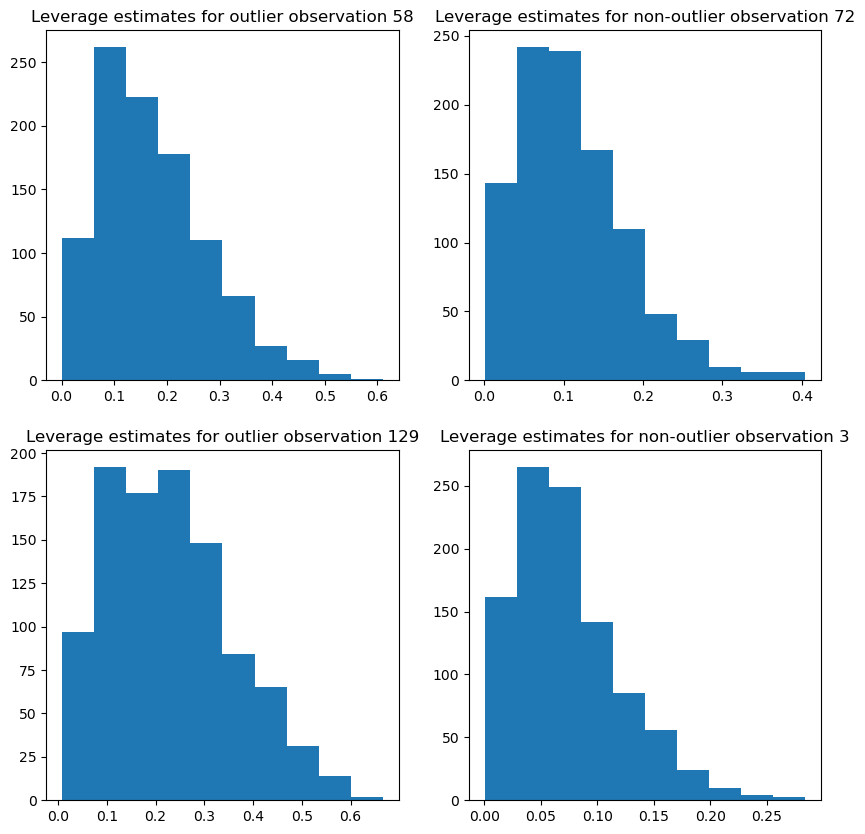

In [6]:
h_cutoff = 2*p/n
summ_out = az.summary(idata_out, round_to=5)
tauis = summ_out.filter(regex='taui\[\d*\]', axis=0)
tau = summ_out.filter(items=['tau'], axis=0)
D = np.eye(n)*(np.array(tauis['mean'])*np.array(tau['mean']))
inv = np.linalg.inv(np.transpose(X_out)@D@X_out)
H = X_out@inv@np.transpose(X_out)@D # hat matrix of WLS
print("leverage points: ", np.array(np.where(np.diagonal(H) > h_cutoff))[0])
print("leverage cutoff: ", h_cutoff)
print("This detects the outliers I added (observations 159 and 160) plus some others.")
print("Let's compare outliers 58, 129 to non-outliers 72, 3 for chain 0")
l = len(idata_out['posterior']['taui'][1])
h58 = np.ones(l); h129 = np.ones(l); h72 = np.ones(l); h3 = np.ones(l)
# for every sample PyMC draws, make a new hat matrix and extract the leverages of our points of interest
for i in range(l):
    Di = np.eye(n)*\
    (idata_out['posterior']['taui'].values[0][i]*idata_out['posterior']['tau'].values[0][i])
    invi = np.linalg.inv(np.transpose(X_out)@Di@X_out)
    Hi = X_out@invi@np.transpose(X_out)@Di
    hi = np.diagonal(Hi)
    h58[i] = hi[58]; h129[i] = hi[129]; h72[i] = hi[72]; h3[i] = hi[3]
print("mean leverage for observation 58: ", np.mean(h58), "\n129: ", np.mean(h129), "\n72: ", np.mean(h72), "\n3: ", np.mean(h3) )
print("Description of observations we're considering\n", fish_data0.iloc[[58, 129, 72, 3],:])
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].hist(h58)
ax[0,0].set_title("Leverage estimates for outlier observation 58")
ax[1,0].hist(h129)
ax[1,0].set_title("Leverage estimates for outlier observation 129")
ax[0,1].hist(h72)
ax[0,1].set_title("Leverage estimates for non-outlier observation 72")
ax[1,1].hist(h3)
ax[1,1].set_title("Leverage estimates for non-outlier observation 3")

The shapes of the leverage values for outliers and non-outliers look the same shape-wise; the non-outlier distributions are centered around smaller values. The non-outliers may be more right skewed than the outlier distributions (outlier observation 129 has a large leverage and looks less right skewed than the other distributions).

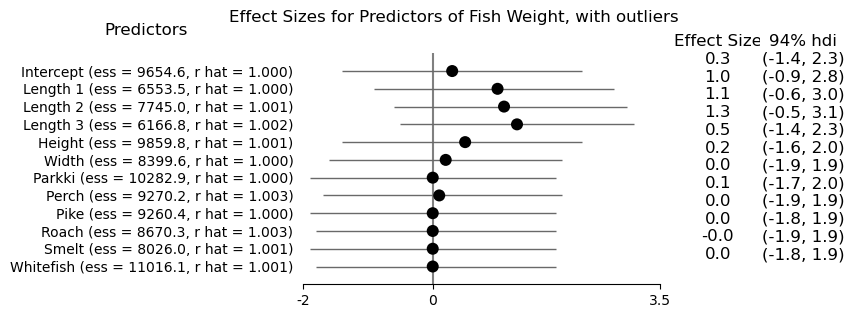

In [10]:
import matplotlib.image as mpimg
import zepid
from zepid.graphics import EffectMeasurePlot
summ_out = az.summary(idata_out, round_to=1)
labs = ["Intercept (ess = 9654.6, r hat = 1.000)",
        "Length 1 (ess = 6553.5, r hat = 1.000)",
        "Length 2 (ess = 7745.0, r hat = 1.001)",
        "Length 3 (ess = 6166.8, r hat = 1.002)",
        "Height (ess = 9859.8, r hat = 1.001)",
       "Width (ess = 8399.6, r hat = 1.000)",
       "Parkki (ess = 10282.9, r hat = 1.000)",
       "Perch (ess = 9270.2, r hat = 1.003)",
       "Pike (ess = 9260.4, r hat = 1.000)",
       "Roach (ess = 8670.3, r hat = 1.003)",
       "Smelt (ess = 8026.0, r hat = 1.001)",
       "Whitefish (ess = 11016.1, r hat = 1.001)"]
measure = list(summ_out["mean"])[0:12]
lower = list(summ_out["hdi_3%"])[0:12]
upper = list(summ_out["hdi_97%"])[0:12]
pt = EffectMeasurePlot(label=labs, effect_measure=measure, lcl=lower, ucl=upper)
pt.labels(effectmeasure='Effect Size', conf_int = "94% hdi", center = 0)
pt.colors(pointshape="o")
ax=pt.plot(figsize=(7,3), t_adjuster=0.09, max_value=3.5, min_value=-2)
plt.title("Effect Sizes for Predictors of Fish Weight, with outliers",loc="center",x=-1.3, y=1.1)
plt.suptitle("Predictors",x=-0.1,y=0.98)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.show()


The outlier points (observations 159, 160) that I added seem to be influential with the magnitude of the effect sizes for almost all predictors being dampened. 